# Fitting an L5PC with gradient descent

In the example below, we will use gradient descent to fit the parameters of a layer 5 pyramidal cell (L5PC). We will be fitting 20 parameters such that the model matches a synthetically generated voltage trace.

In [1]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import jaxley as jx
from jaxley.channels import Leak
from jaxley_mech.channels.l5pc import *
from jaxley.morphology import distance_direct

# To suppress Pandas performance warnings:
import pandas as pd
import warnings
warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)

## Defining the model

First, we will read the morphology from an SWC file. We specify the axial resistance and the capacitance and then run the d_lambda rule to set the number of compartments in each branch.

In [3]:
cell = jx.read_swc("../../tests/swc_files/morph_l5pc_with_axon.swc", ncomp=1)

cell.set("axial_resistivity", 100.0)
cell.apical.set("capacitance", 2.0)

# Run the d_lambda rule.
frequency = 100.0
d_lambda = 0.1  # Larger -> more coarse-grained.

for branch in cell.branches:
    diameter = 2 * branch.nodes["radius"].to_numpy()[0]
    c_m = branch.nodes["capacitance"].to_numpy()[0]
    r_a = branch.nodes["axial_resistivity"].to_numpy()[0]
    l = branch.nodes["length"].to_numpy()[0]

    lambda_f = 1e5 * np.sqrt(diameter / (4 * np.pi * frequency * c_m * r_a))
    ncomp = int((l / (d_lambda * lambda_f) + 0.9) / 2) * 2 + 1
    branch.set_ncomp(ncomp, initialize=False)
cell.initialize()

Cell with 0 different channels. Use `.nodes` for details.

### Inserting ion channels

Next, we insert ion channels into soma, dendrite, and axon.

In [4]:
########## APICAL ##########
cell.apical.insert(NaTs2T())
cell.apical.insert(SKv3_1())
cell.apical.insert(M())
cell.apical.insert(H())

########## SOMA ##########
cell.soma.insert(NaTs2T())
cell.soma.insert(SKv3_1())
cell.soma.insert(SKE2())
ca_dynamics = CaNernstReversal()
ca_dynamics.channel_constants["T"] = 307.15
cell.soma.insert(ca_dynamics)
cell.soma.insert(CaPump())
cell.soma.insert(CaHVA())
cell.soma.insert(CaLVA())

########## BASAL ##########
cell.basal.insert(H())

# ########## AXON ##########
cell.insert(CaNernstReversal())
cell.axon.insert(NaTaT())
cell.axon.insert(NapEt2())
cell.axon.insert(KTst())
cell.axon.insert(CaPump())
cell.axon.insert(SKE2())
cell.axon.insert(CaHVA())
cell.axon.insert(KPst())
cell.axon.insert(SKv3_1())
cell.axon.insert(CaLVA())

########## WHOLE CELL ##########
cell.insert(Leak())

### Specifying the protocol

We then specify the recording sites and the stimulus. In this case, we stimulate the cell for 90 ms with a strong step current of 1.8 nA.

In [5]:
dt = 0.025  # ms
t_max = 100.0  # ms
time_vec = np.arange(0, t_max+2*dt, dt)

cell.delete_stimuli()
cell.delete_recordings()

i_delay = 5.0  # ms
i_dur = 90.0  # ms
i_amp = 1.8  # nA
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.soma.branch(0).loc(0.5).stimulate(current)
cell.soma.branch(0).loc(0.5).record()

cell.set("v", -72.0)
cell.init_states()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


### Generating the observation

Next, we have to define the observation that we will aim to fit this cell to. In this example, we will fit the cell to a synthetic recording with known ground truth parameters. We will now set these ground truth parameters.

In [6]:
cell.set("CaCon_i", 5e-05)
cell.set("CaCon_e", 2.0)

cell.apical.set("NaTs2T_gNaTs2T", 0.026145)
cell.apical.set("SKv3_1_gSKv3_1", 0.004226)
cell.apical.set("M_gM", 0.000143)
cell.soma.set("NaTs2T_gNaTs2T", 0.983955)
cell.soma.set("SKv3_1_gSKv3_1", 0.303472)
cell.soma.set("SKE2_gSKE2", 0.008407)
cell.soma.set("CaPump_gamma", 0.000609)
cell.soma.set("CaPump_decay", 210.485291)
cell.soma.set("CaHVA_gCaHVA", 0.000994)
cell.soma.set("CaLVA_gCaLVA", 0.000333)

cell.axon.set("NaTaT_gNaTaT", 3.137968)
cell.axon.set("NapEt2_gNapEt2", 0.006827)
cell.axon.set("KTst_gKTst", 0.089259)
cell.axon.set("CaPump_gamma", 0.00291)
cell.axon.set("CaPump_decay", 287.19873)
cell.axon.set("SKE2_gSKE2", 0.007104)
cell.axon.set("CaHVA_gCaHVA", 0.00099)
cell.axon.set("KPst_gKPst", 0.973538)
cell.axon.set("SKv3_1_gSKv3_1", 1.021945)
cell.axon.set("CaLVA_gCaLVA", 0.008752)

# The H-conductance depends on the distance from the soma.
cell.compute_compartment_centers()
direct_dists = distance_direct(cell.soma.branch(0).comp(0), cell)
cell.nodes["dist_from_soma"] = direct_dists
gH_conductance = (-0.8696 + 2.087 * np.exp(cell.basal.nodes["dist_from_soma"] * 0.0031)) * 8e-5
cell.basal.set("H_gH", gH_conductance)

cell.set("Leak_gLeak", 3e-05)
cell.set("Leak_eLeak", -75.0)

cell.set("eNa", 50.0)
cell.set("eK", -85.0)

We then run the simulation and save it as the observation $x_o$.

In [7]:
x_o = jx.integrate(cell)[0]  # [0] gets rid of the batch-dimension.

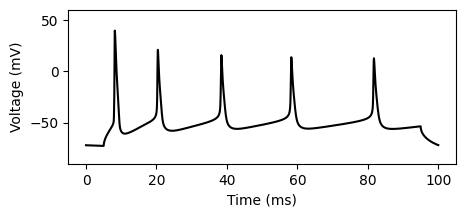

In [8]:
    fig, ax = plt.subplots(1, 1, figsize=(5.0, 2.0))
    _ = ax.plot(time_vec, x_o, c="k")
    _ = ax.set_ylim([-90, 60])
    _ = ax.set_xlabel("Time (ms)")
    _ = ax.set_ylabel("Voltage (mV)")
    plt.show()

## Fitting model parameters

Let's turn to fitting the parameters of this model. As first step, we specify parameter bounds for the fitting procedure:

In [9]:
bounds = {}
bounds["apical_NaTs2T_gNaTs2T"] = [0, 0.04]
bounds["apical_SKv3_1_gSKv3_1"] = [0, 0.04]
bounds["apical_M_gM"] = [0, 0.001]
bounds["somatic_NaTs2T_gNaTs2T"] = [0.0, 1.0]
bounds["somatic_SKv3_1_gSKv3_1"] = [0.25, 1]
bounds["somatic_SKE2_gSKE2"] = [0, 0.1]
bounds["somatic_CaPump_gamma"] = [0.0005,0.01]
bounds["somatic_CaPump_decay"] = [20, 1_000]
bounds["somatic_CaHVA_gCaHVA"] = [0, 0.001]
bounds["somatic_CaLVA_gCaLVA"] = [0, 0.01]
bounds["axonal_NaTaT_gNaTaT"] = [0.0, 4.0]
bounds["axonal_NapEt2_gNapEt2"] = [0.0, 0.01]
bounds["axonal_KPst_gKPst"] = [0.0, 1.0]
bounds["axonal_KTst_gKTst"] = [0.0, 0.1]
bounds["axonal_SKE2_gSKE2"] = [0.0, 0.1]
bounds["axonal_SKv3_1_gSKv3_1"] = [0.0, 2.0]
bounds["axonal_CaHVA_gCaHVA"] = [0, 0.001]
bounds["axonal_CaLVA_gCaLVA"] = [0, 0.01]
bounds["axonal_CaPump_gamma"] = [0.0005, 0.05]
bounds["axonal_CaPump_decay"] = [20, 1_000]

# Extract the lower and upper bounds as an array, for convenience later.
lower_bounds = jnp.asarray(list(bounds.values()))[:, 0]
upper_bounds = jnp.asarray(list(bounds.values()))[:, 1]

For gradient descent, it is helpful if parameters are standardized (i.e., are unbounded and roughly range from -3 to 3). We achieve this by transforming the parameters with a sigmoid transformation:

In [10]:
from jaxley.optimize.transforms import SigmoidTransform

transform = SigmoidTransform(
    lower=lower_bounds,
    upper=upper_bounds,
)

We then specify the number of checkpointing steps to reduce memory consumption:

In [11]:
# For checkpointing.
checkpoint_levels = 2
checkpoints = [int(np.ceil(len(time_vec)**(1 / checkpoint_levels))) for _ in range(checkpoint_levels)]

Next, we specify the simulator. The simulator takes as input 20 values (the parameters), sets the corresponding maximal conductances to these parameters, and then runs the simulation (with checkpointing):

In [12]:
def simulate(params):
    # Set apical parameters.
    pstate = None
    pstate = cell.apical.data_set("NaTs2T_gNaTs2T", params[0], pstate)
    pstate = cell.apical.data_set("SKv3_1_gSKv3_1", params[1], pstate)
    pstate = cell.apical.data_set("M_gM", params[2], pstate)
    
    # Set somatic parameters.
    pstate = cell.soma.data_set("NaTs2T_gNaTs2T", params[3], pstate)
    pstate = cell.soma.data_set("SKv3_1_gSKv3_1", params[4], pstate)
    pstate = cell.soma.data_set("SKE2_gSKE2", params[5], pstate)
    pstate = cell.soma.data_set("CaPump_gamma", params[6], pstate)
    pstate = cell.soma.data_set("CaPump_decay", params[7], pstate)
    pstate = cell.soma.data_set("CaHVA_gCaHVA", params[8], pstate)
    pstate = cell.soma.data_set("CaLVA_gCaLVA", params[9], pstate)
    
    # Set axonal parameters.
    pstate = cell.axon.data_set("NaTaT_gNaTaT", params[10], pstate)
    pstate = cell.axon.data_set("NapEt2_gNapEt2", params[11], pstate)
    pstate = cell.axon.data_set("KPst_gKPst", params[12], pstate)
    pstate = cell.axon.data_set("KTst_gKTst", params[13], pstate)
    pstate = cell.axon.data_set("SKE2_gSKE2", params[14], pstate)
    pstate = cell.axon.data_set("SKv3_1_gSKv3_1", params[15], pstate)
    pstate = cell.axon.data_set("CaHVA_gCaHVA", params[16], pstate)
    pstate = cell.axon.data_set("CaLVA_gCaLVA", params[17], pstate)
    pstate = cell.axon.data_set("CaPump_gamma", params[18], pstate)
    pstate = cell.axon.data_set("CaPump_decay", params[19], pstate)

    # Return [0] because the result of `jx.integrate` is of shape (1, time). Here, we
    # get rid of the batch dimension.
    return jx.integrate(cell, param_state=pstate, checkpoint_lengths=checkpoints)[0]

jitted_sim = jax.jit(simulate)
vmapped_sim = jax.jit(jax.vmap(simulate, in_axes=(0,)))

### Initializing the fitting

We initialize the fitting run with a random sample within the optimization bounds:

In [13]:
def sample_randomly():
    return jnp.asarray(np.random.rand(len(upper_bounds)) * (upper_bounds - lower_bounds) + lower_bounds)

_ = np.random.seed(0)
initial_params = sample_randomly()

This initial parameter set does not yet match the observation well:

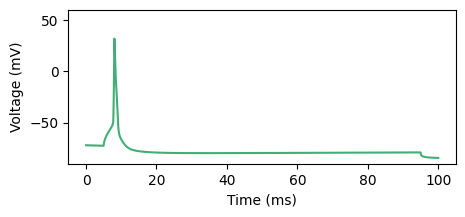

In [14]:
v = simulate(initial_params)

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
_ = ax.plot(time_vec, v.T, c="#41ae76")
_ = ax.set_ylim([-90, 60])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")
plt.show()

### Defining the loss function

We then define the loss function to optimize. In this example, we use the mean and standard deviation of two time windows describing the first 50 ms and the second 50 ms as summary statistics:

In [15]:
window1 = jnp.arange(200, 2000)  # Unit: time steps.
window2 = jnp.arange(2000, 3800)

def summary_stats(v):
    mean1 = jnp.mean(v[window1])
    std1 = jnp.std(v[window1])
    mean2 = jnp.mean(v[window2])
    std2 = jnp.std(v[window2])
    return jnp.asarray([mean1, std1, mean2, std2])

# Compute the summary statistics of the observation.
x_o_ss = summary_stats(x_o)

...and we then optimize the mean absolute error to these summary statistics (standardized by a `x_standard_deviation` which is used to weigh individual summary statistics):

In [16]:
x_standard_deviation = jnp.asarray([2.0, 1.0, 2.0, 1.0])  # Large values downweigh the respective summary statistic.

def loss_fn(opt_params):
    params = transform.forward(opt_params)
    v = simulate(params)
    ss = summary_stats(v)
    return jnp.mean(jnp.abs((ss - x_o_ss) / x_standard_deviation))

jitted_loss_fn = jax.jit(loss_fn)
grad_fn = jax.jit(jax.value_and_grad(loss_fn))

### Run gradient descent

To run gradient descent, we first transform the parameters with the transformation defined above:

In [17]:
opt_params = transform.inverse(initial_params)

Next, we define the optimizer. For morphologically detailed neurons, the gradient can sometimes be unstable---to overcome this, we use a Polyak style learning rate:

$$
\Delta \theta = -\frac{\mu \mathcal{L}}{\lVert \nabla_{\theta} L \rVert^{\beta}} \cdot \nabla_{\theta}{L}
$$

In other words, we to divide the gradient by its norm (to the power of $\beta$, which is $\approx 1.0$) and we scale the gradient by the loss $\mathcal{L}$ (this leads to smaller learning rates if the loss is small) and a learning rate $\mu$. This optimizer can be implemented as follows:

In [18]:
import optax
from jaxley.optimize.utils import l2_norm

# We scale the learning rate with the number of parameters. Since
# the gradient gets divided by its own norm, it typically gets
# divided by larger numbers for models with many parameters.
# Choosing mu as below counteracts this.
#
# Also note that this learning rate is relatively high---you might
# want to explore smaller learning rates.
mu = 0.1 * l2_norm(jnp.ones(len(opt_params)))

beta = 0.9  # Good values are typically between 0.8 and 1.2.

optimizer = optax.inject_hyperparams(optax.sgd)(learning_rate=mu)
opt_state = optimizer.init(opt_params)

for epoch in range(10):
    loss_val, grad_val = grad_fn(opt_params)

    # Polyak style learning rate.
    grad_val = grad_val / l2_norm(grad_val)**beta
    opt_state.hyperparams["learning_rate"] = loss_val * mu
    
    # Update parameters and optimizer.
    updates, opt_state = optimizer.update(grad_val, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)
    
    print(f"Loss in epoch {epoch}: {loss_val:.4f}")

loss in epoch 0: 10.0732
loss in epoch 1: 2.3877
loss in epoch 2: 5.3513
loss in epoch 3: 1.0662
loss in epoch 4: 1.3743
loss in epoch 5: 0.9470
loss in epoch 6: 1.1267
loss in epoch 7: 0.9565
loss in epoch 8: 0.8096
loss in epoch 9: 0.8362


> Please note that these choices for $\mu$ and $\beta$, as well as the choice of a Polyak style learning rate are optimized for fitting single neuron models. For other tasks (in particular for networks), other optimizers and hyperparameters might perform better.

### Evaluating the fit

After the optimization is complete, we can compare the fitted trace to the observation:

In [19]:
params = transform.forward(opt_params)
fitted_trace = jitted_sim(params)

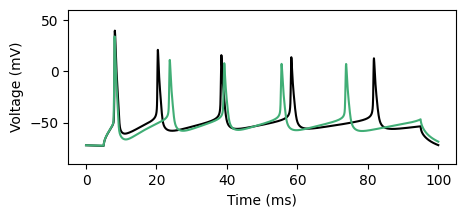

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5.0, 2.0))
_ = ax.plot(time_vec, x_o, c="k")
_ = ax.plot(time_vec, fitted_trace, c="#41ae76")
_ = ax.set_ylim([-90, 60])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")
plt.show()

That's it! We fitted a L5PC with gradient descent. You can try to further improve fitting as follows:

- Use a different learning rate $\mu$ (especially later in training).  
- Use different summary statistics.  
- Paralellize many fitting runs with randomly chosen initializations (especially on GPU).  

Beyond this, we also recommend the following:
- It is often helpful to perform a quick random search and start gradient descent from the "best" parameter set. Initialization can vastly impact gradient descent performance.  
- Generally, monitor the `l2_norm(grad_val)` during training. If this value is extremely variable across steps, you might want to set $\beta$ closer to `1.0` (such that the gradient gets normalized to be of norm ~1.0 at every gradient step), or you should clip the gradients.  

Finally, we note that `Jaxley` can be combined with other fitting methods such as random search, simulation-based inference, or genetic algorithms. For these methods, `Jaxley` can parallelize simulations with `jax.vmap`. Especially for models with relatively few parameters, these methods can perform well.